In [1]:
%matplotlib inline

import os
import re
from pathlib import Path
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.style.use('ggplot')

def snake(string):
    "convert string to lower snakecase"
    s = re.sub('[^0-9a-zA-Z]+', '_', string)
    s = s.lower()
    s = s.strip('_')

    return s

def format_cols(df):
    """format df column names to snake"""
    cols = df.columns.tolist()
    cols = [snake(name) for name in cols]
    df.columns = cols
    return df

def download_bls_file(url):
    """helper function to download BLS time series files"""
    
    # get cleaned filename from url
    file_name = url.split('/')[-1]
    file_name = "./data/" + file_name + ".txt"
    
    # check if file exists, else download
    my_file = Path(file_name)
    if my_file.is_file():
        print("already exists: " + file_name)
        return file_name
    else:
        urllib.request.urlretrieve(url, file_name)
        return file_name

## CES Data

In [2]:
# download primary data, metadata, and merge all into one big dataframe

# this first file is large-ish. >350MB
url = "https://download.bls.gov/pub/time.series/ce/ce.data.0.AllCESSeries"
file_name = download_bls_file(url)
all_series_df = pd.read_table(file_name)

url = "https://download.bls.gov/pub/time.series/ce/ce.industry"
file_name = download_bls_file(url)
industry_df = pd.read_table(file_name, header=0, index_col=False)

url = "https://download.bls.gov/pub/time.series/ce/ce.series"
file_name = download_bls_file(url)
series_df = pd.read_table(file_name, index_col=False)

url = "https://download.bls.gov/pub/time.series/ce/ce.datatype"
file_name = download_bls_file(url)
datatype_df = pd.read_table(file_name, index_col=False)

url = "https://download.bls.gov/pub/time.series/ce/ce.period"
file_name = download_bls_file(url)
period_df = pd.read_table(file_name, index_col=False, header=None)
period_df.columns = ['period_code', 'period_abv', 'period_text']
    
url = "https://download.bls.gov/pub/time.series/ce/ce.supersector"
file_name = download_bls_file(url)
supersector_df = pd.read_table(file_name, index_col=False)

supersector_color_list = [
    (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
    (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
    (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
    (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
    (1.0, 0.7333333333333333, 0.47058823529411764),
    (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
    (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
    (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
    (0.8705882352941177, 0.6196078431372549, 0.8392156862745098),
    (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
    (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
    (1.0, 0.596078431372549, 0.5882352941176471),
    (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
    (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
    (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
    (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
    (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    (0.807843137254902, 0.8588235294117647, 0.611764705882353)
]
supersector_df['supersector_color'] = supersector_color_list

all_series_df = all_series_df.merge(series_df, on=['series_id', 'footnote_codes'])
all_series_df = all_series_df.merge(industry_df, on='industry_code')
all_series_df = all_series_df.merge(datatype_df, on='data_type_code')
all_series_df = all_series_df.merge(supersector_df, on='supersector_code')

already exists: ./data/ce.data.0.AllCESSeries.txt
already exists: ./data/ce.industry.txt
already exists: ./data/ce.series.txt
already exists: ./data/ce.datatype.txt
already exists: ./data/ce.period.txt
already exists: ./data/ce.supersector.txt


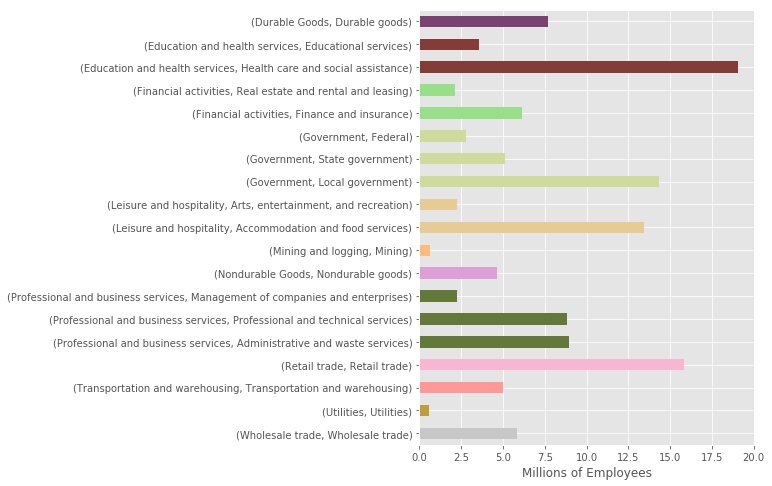

In [3]:
industry_level = all_series_df.display_level == 3
employment_filter = all_series_df.data_type_code==1
annual_data_filter = all_series_df.period=='M13'
year_filter = all_series_df.year==2016

_df = all_series_df[industry_level&employment_filter&annual_data_filter&year_filter][['supersector_name','industry_name','value', 'supersector_color']]
_df['value'] = _df['value'] / 1000
_df = _df.sort_values(['supersector_name', 'value'], ascending=False)
_ax = _df.set_index(['supersector_name','industry_name'])['value'].plot(
    kind='barh',
    color=_df['supersector_color'], 
    figsize=(6,8)
)

_ax.set_xlabel('Millions of Employees')
_ax.set_ylabel('')

plt.savefig(
    './output/employment_2016_barh.svg', 
    transparent=False,
    bbox_inches='tight'
)

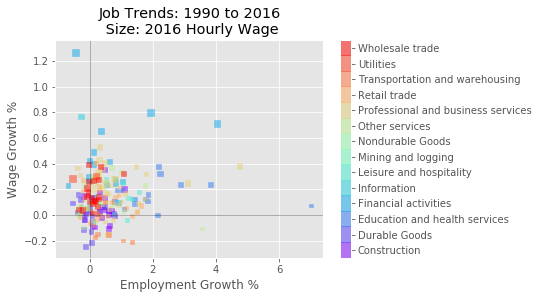

In [4]:
industry_level = all_series_df.display_level == 6
employment_filter = all_series_df.data_type_code==1
annual_data_filter = all_series_df.period=='M13'
year_filter = all_series_df.year.isin([1990,2016])

_df = (
    all_series_df
    [
        industry_level
        &employment_filter
        &annual_data_filter
        &year_filter
    ]
    [[
        'supersector_name'
        ,'industry_name'
        ,'year'
        ,'value'
        ,'supersector_color'
    ]]
)

_df = _df.set_index(['supersector_name','industry_name','year'])['value'].unstack()

_df['job_growth_pct'] = (_df[2016] - _df[1990]) / _df[1990]
_df['current_employment'] = _df[2016]

job_growth_df = _df.copy()

#
# wages
#

# AVERAGE HOURLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES, 1982-84 DOLLARS
employment_filter = all_series_df.data_type_code==32

_df = (
    all_series_df
    [
        industry_level
        &employment_filter
        &annual_data_filter
        &year_filter
    ]
    [[
        'supersector_name'
        ,'industry_name'
        ,'year'
        ,'value'
    ]]
)

_df = _df.set_index(['supersector_name','industry_name','year'])['value'].unstack()

# convert to 2016 dollars
# from: https://data.bls.gov/cgi-bin/cpicalc.pl
# 1983 to 2016
inflation_mulitplier = 2.42

_df = _df * inflation_mulitplier

_df['wage_growth_pct'] = (_df[2016] - _df[1990]) / _df[1990]
_df['current_wages'] = _df[2016]

wage_growth_df = _df.copy()

#
# merged
#

_df = pd.merge(
    wage_growth_df[['wage_growth_pct', 'current_wages']]
    ,job_growth_df[['job_growth_pct','current_employment']]
    ,how='inner'
    ,left_index=True
    ,right_index=True
)

_df = _df.reset_index()

_df = _df.merge(supersector_df[['supersector_name', 'supersector_color']], on='supersector_name')

_df['cat'] = _df.supersector_name.astype("category").cat.codes

plt.scatter( 
    _df.job_growth_pct
    ,_df.wage_growth_pct
    ,s=_df.current_wages
    ,alpha=.5
    ,marker='s'
    ,c= _df['cat']
    ,cmap= plt.cm.get_cmap('rainbow', 14)
)

plt.title('Job Trends: 1990 to 2016\n Size: 2016 Hourly Wage')

plt.xlabel('Employment Growth %')
plt.ylabel('Wage Growth %')

target_labels = _df[['cat','supersector_name']].set_index('cat').to_dict()['supersector_name']
# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: target_labels[val])
# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=[i for i in range(14)], format=formatter);
# Set the clim so that labels are centered on each block
plt.clim(-.5, 13.5)

plt.axhline(alpha=.3, lw=1, color='black')
plt.axvline(alpha=.3, lw=1, color='black')

#
# stash results
#

trends_1990 = (
    _df
        [[
            'supersector_name', 
            'industry_name', 
            'wage_growth_pct',
            'job_growth_pct',
            'current_wages'
        ]]
)

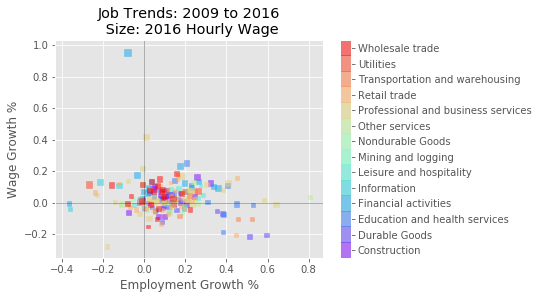

In [5]:
industry_level = all_series_df.display_level == 6
employment_filter = all_series_df.data_type_code==1
annual_data_filter = all_series_df.period=='M13'
year_filter = all_series_df.year.isin([2009,2016])

_df = (
    all_series_df
    [
        industry_level
        &employment_filter
        &annual_data_filter
        &year_filter
    ]
    [[
        'supersector_name'
        ,'industry_name'
        ,'year'
        ,'value'
        ,'supersector_color'
    ]]
)

_df = _df.set_index(['supersector_name','industry_name','year'])['value'].unstack()

_df['job_growth_pct'] = (_df[2016] - _df[2009]) / _df[2009]
_df['current_employment'] = _df[2016]

job_growth_df = _df.copy()

#
# wages
#

# AVERAGE HOURLY EARNINGS OF PRODUCTION AND NONSUPERVISORY EMPLOYEES, 1982-84 DOLLARS
employment_filter = all_series_df.data_type_code==32

_df = (
    all_series_df
    [
        industry_level
        &employment_filter
        &annual_data_filter
        &year_filter
    ]
    [[
        'supersector_name'
        ,'industry_name'
        ,'year'
        ,'value'
    ]]
)

_df = _df.set_index(['supersector_name','industry_name','year'])['value'].unstack()

# convert to 2016 dollars
# from: https://data.bls.gov/cgi-bin/cpicalc.pl
# 1983 to 2016
inflation_mulitplier = 2.42

_df = _df * inflation_mulitplier

_df['wage_growth_pct'] = (_df[2016] - _df[2009]) / _df[2009]
_df['current_wages'] = _df[2016]

wage_growth_df = _df.copy()

#
# merged
#

_df = pd.merge(
    wage_growth_df[['wage_growth_pct', 'current_wages']]
    ,job_growth_df[['job_growth_pct','current_employment']]
    ,how='inner'
    ,left_index=True
    ,right_index=True
)

_df = _df.reset_index()

_df = _df.merge(supersector_df[['supersector_name', 'supersector_color']], on='supersector_name')

_df['cat'] = _df.supersector_name.astype("category").cat.codes

plt.scatter( 
    _df.job_growth_pct
    ,_df.wage_growth_pct
    ,s=_df.current_wages
    ,alpha=.5
    ,marker='s'
    ,c= _df['cat']
    ,cmap= plt.cm.get_cmap('rainbow', 14)
)

plt.title('Job Trends: 2009 to 2016\n Size: 2016 Hourly Wage')

plt.xlabel('Employment Growth %')
plt.ylabel('Wage Growth %')

target_labels = _df[['cat','supersector_name']].set_index('cat').to_dict()['supersector_name']
# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: target_labels[val])
# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=[i for i in range(14)], format=formatter);
# Set the clim so that labels are centered on each block
plt.clim(-.5, 13.5)

plt.axhline(alpha=.3, lw=1, color='black')
plt.axvline(alpha=.3, lw=1, color='black')

#
# save
#

trends_2009 = (
    _df
        [[
            'supersector_name', 
            'industry_name', 
            'wage_growth_pct',
            'job_growth_pct',
        ]]
)

In [6]:
merged_trends = pd.merge(
    trends_1990, trends_2009, 
    on=['supersector_name', 'industry_name'], 
    suffixes=('_1990','_2009')
)

merged_trends.to_csv('./output/wage_trends.csv', index=False)

## CPS Survey Data for Gender

Download files

In [7]:
url = "https://download.bls.gov/pub/time.series/le/le.series"
file_name = download_bls_file(url)
le_series_df = pd.read_table(file_name)
le_series_df.series_id = le_series_df.series_id.str.strip()

url = "https://download.bls.gov/pub/time.series/le/le.data.1.AllData"
file_name = download_bls_file(url)
le_all_df = pd.read_table(file_name)
le_all_df.series_id = le_all_df.series_id.str.strip()

url = "https://download.bls.gov/pub/time.series/le/le.occupation"
file_name = download_bls_file(url)
le_occupation_df = pd.read_table(file_name, header=0, index_col=False)

already exists: ./data/le.series.txt
already exists: ./data/le.data.1.AllData.txt
already exists: ./data/le.occupation.txt


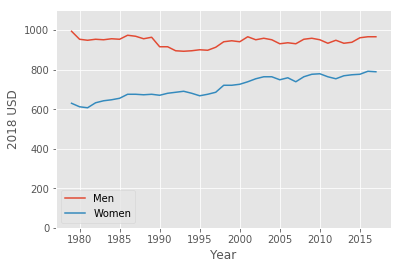

In [8]:
gendered_wage_series_codes = ['LES1252881900','LES1252882800']

_df = le_all_df[(le_all_df.series_id.isin(gendered_wage_series_codes))&(le_all_df.period=='Q04')].copy()
_df.value = _df.value.str.strip()

# convert to 2016 dollars
# from: https://data.bls.gov/cgi-bin/cpicalc.pl
# 1983 to 2018
inflation_mulitplier = 2.53
_df.value = _df.value.apply(float) * inflation_mulitplier

_df = _df.pivot(index='year', columns='series_id', values='value')

_df.columns=['Men', 'Women']

_ax = _df.plot(ylim=(0,1100))
_ax.set_xlabel('Year')
_ax.set_ylabel('2018 USD')

# save plot to svg and expand bounds to include legend
_filename = "./output/weekly_by_gender.svg"

plt.savefig(
    _filename, 
#     bbox_extra_artists=([lgd]), 
    bbox_inches='tight'
)

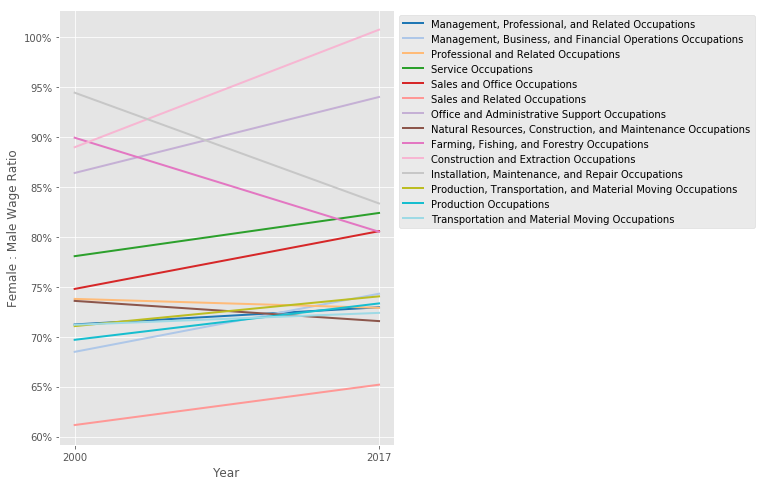

In [9]:
gendered_wages_by_occ_seriescodes = [
    'LEU0254631400',
     'LEU0254631500',
     'LEU0254637000',
     'LEU0254650200',
     'LEU0254657000',
     'LEU0254657100',
     'LEU0254659000',
     'LEU0254664200',
     'LEU0254664300',
     'LEU0254665300',
     'LEU0254669300',
     'LEU0254673000',
     'LEU0254673100',
     'LEU0254681300',
     'LEU0254738200',
     'LEU0254738300',
     'LEU0254743800',
     'LEU0254757000',
     'LEU0254763800',
     'LEU0254763900',
     'LEU0254765800',
     'LEU0254771000',
     'LEU0254771100',
     'LEU0254772100',
     'LEU0254776100',
     'LEU0254779800',
     'LEU0254779900',
     'LEU0254788100']

_df = le_all_df[
    (le_all_df.series_id.isin(gendered_wages_by_occ_seriescodes))
    &(le_all_df.year.isin([2000,2017]))
    &(le_all_df.period=='Q05')
].copy()

_df.value= _df.value.apply(float)

_df = _df.merge(le_series_df[['series_id', 'occupation_code', 'sexs_code']], on='series_id')

_df = _df.merge(le_occupation_df, on='occupation_code')

_df_2000 =_df[_df.year==2000]
_df_2017 =_df[_df.year==2017]

_ser_2000 = 100* _df_2000[_df_2000.sexs_code==2].set_index('occupation_text')['value'] / _df_2000[_df_2000.sexs_code==1].set_index('occupation_text')['value']
_ser_2017 = 100 *_df_2017[_df_2017.sexs_code==2].set_index('occupation_text')['value'] / _df_2017[_df_2017.sexs_code==1].set_index('occupation_text')['value']

_df = pd.DataFrame()

_df[2000] = _ser_2000
_df[2017] = _ser_2017

_ax = _df.T.plot(cmap='tab20', lw=2, alpha=1, figsize=(6,8))

_ax.xaxis.set_ticks([2000,2017])
_ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))

_ax.set_ylabel('Female : Male Wage Ratio')
_ax.set_xlabel('Year')

# place legend outside plot
lgd = plt.legend(
    loc="best",
    bbox_to_anchor=(1,1)
)

# save plot to svg and expand bounds to include legend
plt.savefig(
    './output/gender_wage_slopes.svg', 
    bbox_extra_artists=([lgd]), 
    bbox_inches='tight'
)

Plot derivative of above

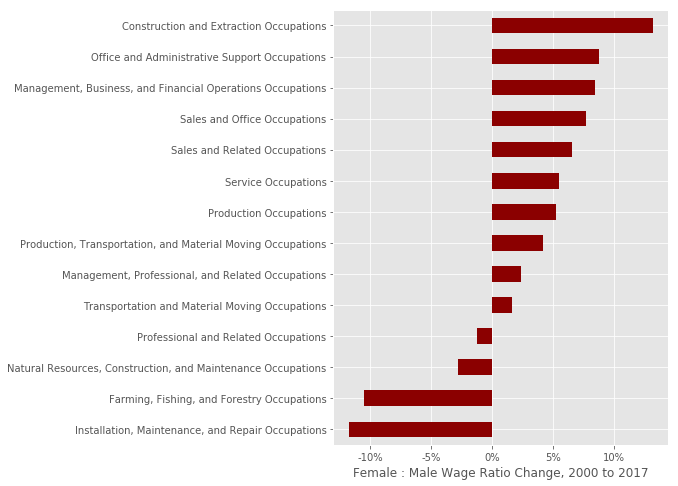

In [10]:
_change = 100* (_df[2017] - _df[2000]) / _df[2000]

_ax = _change.sort_values().plot.barh(color='darkred', figsize=(6,8))

_ax.xaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
_ax.set_ylabel('')
_ax.set_xlabel('Female : Male Wage Ratio Change, 2000 to 2017')

plt.savefig(
    './output/barh_gender_change.svg', 
    bbox_inches='tight'
)